Make sure DMBA package is available

In [ ]:
pip install dmba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 19.5 MB/s eta 0:00:00


In [ ]:
!apt-get -qq install -y graphviz && pip install mord
import mord

  Preparing metadata (setup.py) ... done
  Created wheel for mord: filename=mord-0.7-py3-none-any.whl size=9886 sha256=177e0d7364db8ca81fc747631b42372314fa6ab8d1e4e8744c77ab30bcc45dcb
  Stored in directory: /root/.cache/pip/wheels/77/00/19/3cea86fbfc737ec4acb515cd94497dcc33f943fa157548b96c
Successfully built mord


In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from mord import LogisticIT
import matplotlib.pylab as plt
import seaborn as sns
import dmba
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score
from sklearn import metrics



%matplotlib inline

Colab environment detected.


In [ ]:
bank_df = dmba.load_data('UniversalBank.csv') #read data
bank_df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [ ]:
bank_df.drop(columns=['ID', 'ZIP Code'], inplace=True) #drop undesired columns
bank_df.columns = [c.replace(' ', '_') for c in bank_df.columns]
bank_df.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,45,19,34,3,1.5,1,0,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,0,1


In [ ]:
# Treat education as categorical, convert to dummy variables
bank_df['Education'] = bank_df['Education'].astype('category')
new_categories = {1: 'Undergrad', 2: 'Graduate', 3: 'Advanced/Professional'} #define levels
bank_df.Education.cat.rename_categories(new_categories) #rename categories based on new levels
bank_df = pd.get_dummies(bank_df, prefix_sep='_', drop_first=True, dtype=int)

y = bank_df['Personal_Loan'] #define the outcome variable
X = bank_df.drop(columns=['Personal_Loan']) #define the predictors

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -12.493436061176814
            Age  Experience    Income    Family     CCAvg  Mortgage  \
coeff -0.037685    0.039202  0.058844  0.612251  0.240489  0.001012   

       Securities_Account  CD_Account    Online  CreditCard  Education_2  \
coeff            -1.01428    3.649097 -0.678306   -0.958283     4.202148   

       Education_3  
coeff     4.355761  

AIC -709.1524769205962


## Table 10.3
Predict to get the probabilities

In [ ]:
logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_y,
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

# display four different cases
interestingCases = [2764, 932, 2721, 702]
print(logit_result.loc[interestingCases])

      actual      p(0)      p(1)  predicted
2764       0  0.976092  0.023908          0
932        0  0.331000  0.669000          1
2721       1  0.031430  0.968570          1
702        1  0.985893  0.014107          0


## Table 10.4

In [ ]:
classificationSummary(train_y, logit_reg.predict(train_X))
classificationSummary(valid_y, logit_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.9600)

       Prediction
Actual    0    1
     0 2683   30
     1   90  197
Confusion Matrix (Accuracy 0.9595)

       Prediction
Actual    0    1
     0 1791   16
     1   65  128


In [15]:
#define metrics
y_pred_proba = logit_reg.predict_proba(valid_X)[::,1]
fpr, tpr, _ = metrics.roc_curve(valid_y,  y_pred_proba)

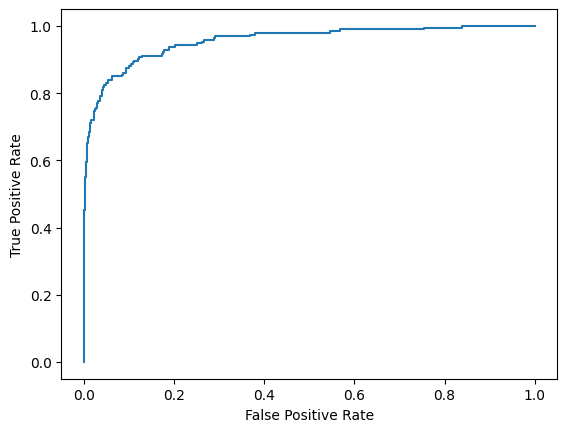

In [16]:
#create ROC curve\
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()